# Plant Disease Classifier using CNN with Data Augmentation

In [1]:
#!tar -xvf  'data-split.tar.xz'

In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from customvggnet import CustomVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import imutils
import json
import random
import pickle
import cv2
import os

In [3]:
# initialize the number of epochs to train for, initial learning rate, batch size, and image dimensions
EPOCHS = 150
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)
# initialize the data and labels
data = []
labels = []
# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("data-split/train")))
random.seed(42)
random.shuffle(imagePaths)

# Data Preprocessing

In [4]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)
    
    # extract the class label from the image path and update the labels list
    # the files are stored as dataset/{CLASS_LABEL}/{FILENAME}.jpg => split will convert it to an array and the 2nd last element will be our filename
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [5]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [6]:
# save the label binarizer to disk
f = open("labels", "wb")
f.write(pickle.dumps(lb))
f.close()

# Image Data Augmentation
Data augmentation is a technique used to take existing images in our dataset and apply random transformations (rotations, shearing, etc.) to generate additional training data.
Data augmentation helps prevent overfitting.
Since we’re working with a limited amount of data points (< 250 images per class), we can make use of data augmentation during the training process to give our model more images (based on existing images) to train with.

In [7]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

# Compiling and Training the Model

In [8]:
# initialize the model
print("Compiling model...")
model = CustomVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

Compiling model...


In [9]:
# train the network
print("Training model...")
history = model.fit(
    x=aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

Training model...
Epoch 1/150
63/63 [==============================] - 8s 79ms/step - loss: 1.2474 - accuracy: 0.6646 - val_loss: 2.2876 - val_accuracy: 0.4764
Epoch 2/150
63/63 [==============================] - 5s 71ms/step - loss: 0.5338 - accuracy: 0.8464 - val_loss: 1.7925 - val_accuracy: 0.4902
Epoch 3/150
63/63 [==============================] - 5s 75ms/step - loss: 0.5048 - accuracy: 0.8490 - val_loss: 3.8716 - val_accuracy: 0.5413
Epoch 4/150
63/63 [==============================] - 5s 73ms/step - loss: 0.3095 - accuracy: 0.8986 - val_loss: 5.4288 - val_accuracy: 0.5098
Epoch 5/150
63/63 [==============================] - 5s 72ms/step - loss: 0.2589 - accuracy: 0.9136 - val_loss: 5.9526 - val_accuracy: 0.4882
Epoch 6/150
63/63 [==============================] - 4s 71ms/step - loss: 0.2847 - accuracy: 0.9041 - val_loss: 7.7134 - val_accuracy: 0.3051
Epoch 7/150
63/63 [==============================] - 4s 71ms/step - loss: 0.3186 - accuracy: 0.9063 - val_loss: 4.2723 - val_accur

In [10]:
# save the model to disk
model.save("model-cnn+aug", save_format="h5")

In [11]:
# save the history
with open('history.json', 'w') as f:
    json.dump(history.history, f)

### Evaluating the Model

In [12]:
# Load model and labels
from keras.models import load_model
model = load_model("model-cnn+aug")
lb = pickle.loads(open("labels", "rb").read())

In [13]:
with open('history.json', 'r') as f:
    history = json.load(f)

In [14]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)

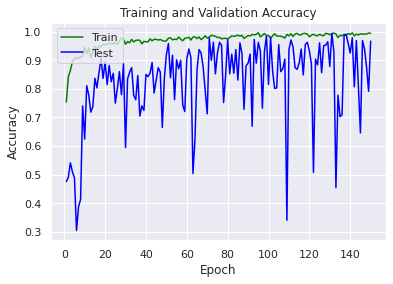

In [15]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

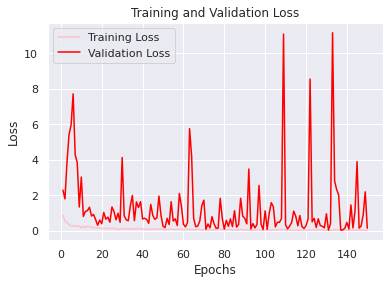

In [16]:
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [17]:
results = model.evaluate(testX, testY)

16/16 [==============================] - 0s 7ms/step - loss: 0.1406 - accuracy: 0.9665


In [18]:
print("Accuracy = {:.2f}%".format(results[1]*100))

Accuracy = 96.65%


### Predictions

In [19]:
from google.colab.patches import cv2_imshow

def get_predictions(image, model):
  output = image.copy()
  # Preprocess the image for classification
  image = cv2.resize(image, (96, 96))
  image = image.astype("float") / 255.0
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)

  # Make the predictions
  proba = model.predict(image)[0]
  idx = np.argmax(proba)
  label = lb.classes_[idx]

  # Display the predictions
  label = "{}: {:.2f}% ".format(label, proba[idx] * 100)
  output = imutils.resize(output, width=400)

  # show the output image
  print("[INFO] {}".format(label))
  cv2_imshow(output)

[INFO] Black-Rot: 100.00% 


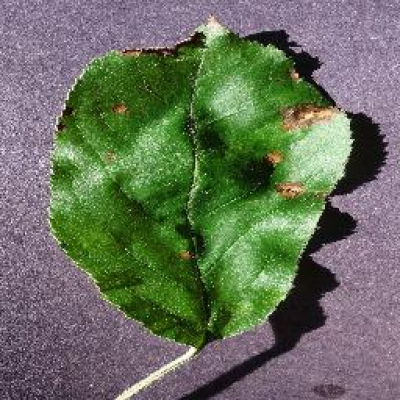

In [20]:
# load the image
image = cv2.imread("/content/data-split/valid/Black-Rot/Black-Rot561.jpg")
get_predictions(image, model)

[INFO] Apple-Scab: 99.99% 


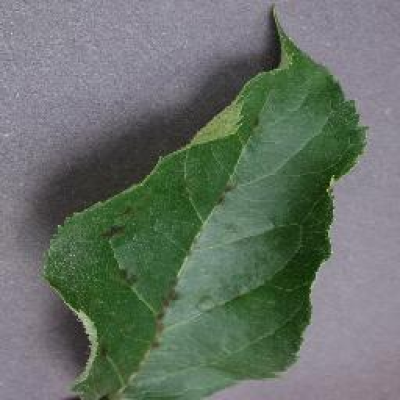

In [21]:
image = cv2.imread("/content/data-split/valid/Apple-Scab/Apple-Scab567.jpg")
get_predictions(image, model)

[INFO] Healthy: 99.97% 


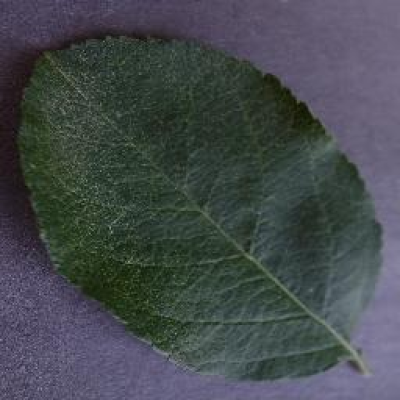

In [22]:
image = cv2.imread("/content/data-split/valid/Healthy/Healthy1489.jpg")
get_predictions(image, model)

[INFO] Healthy: 100.00% 


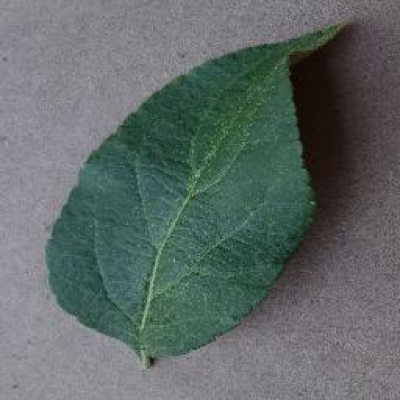

In [23]:
image = cv2.imread("/content/data-split/valid/Healthy/Healthy1502.jpg")
get_predictions(image, model)

[INFO] Cedar-Apple-Rust: 99.99% 


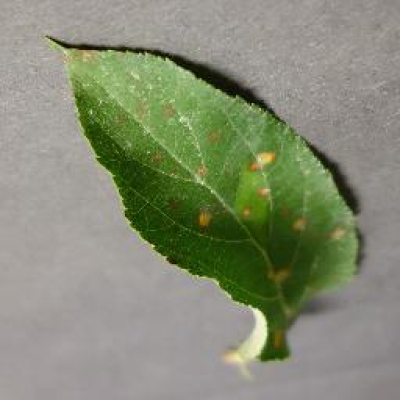

In [24]:
image = cv2.imread("/content/data-split/valid/Cedar-Apple-Rust/Cedar-Apple-Rust255.jpg")
get_predictions(image, model)

[INFO] Cedar-Apple-Rust: 100.00% 


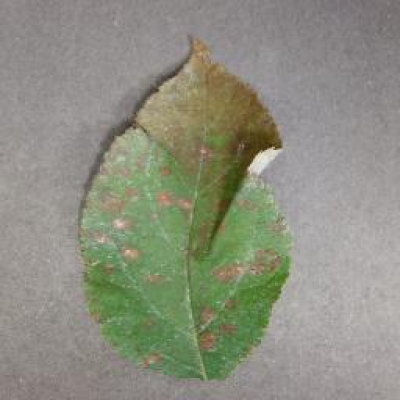

In [25]:
image = cv2.imread("/content/data-split/valid/Cedar-Apple-Rust/Cedar-Apple-Rust271.jpg")
get_predictions(image, model)